In [1]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import open3d as o3d

import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
folder_path = Path("images")
if not folder_path.exists():
    raise FileNotFoundError(f"Folder {folder_path} does not exist.")

num_samples = 1
selection = random.sample(os.listdir(folder_path), num_samples)
selected_images = []


selected_images = []
for i in range(num_samples):
    pathi = str(folder_path / selection[i])
    selected_image = cv2.imread(pathi)
    selected_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
    selected_images.append(selected_image)


    

[array([[[221, 218, 237],
        [221, 218, 237],
        [221, 218, 237],
        ...,
        [234, 223, 239],
        [235, 224, 240],
        [235, 224, 240]],

       [[221, 218, 237],
        [221, 218, 237],
        [221, 218, 237],
        ...,
        [234, 223, 239],
        [235, 224, 240],
        [235, 224, 240]],

       [[221, 218, 237],
        [221, 218, 237],
        [221, 218, 237],
        ...,
        [234, 223, 239],
        [235, 224, 240],
        [235, 224, 240]],

       ...,

       [[124, 139,  70],
        [122, 137,  68],
        [123, 138,  69],
        ...,
        [170, 124,  88],
        [168, 122,  86],
        [166, 120,  84]],

       [[123, 138,  69],
        [119, 134,  65],
        [122, 137,  68],
        ...,
        [176, 130,  94],
        [173, 127,  91],
        [169, 123,  87]],

       [[120, 135,  66],
        [117, 132,  63],
        [120, 135,  66],
        ...,
        [181, 135,  99],
        [179, 133,  97],
        [174, 128,  92]

In [10]:
checkpoint = "LiheYoung/depth-anything-large-hf"

processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint).to("cuda")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
from tqdm import tqdm

depth_samples = []

for i in tqdm(range(num_samples), desc="Processing images"):
    depth_input = processor(selected_images[i], return_tensors="pt").to("cuda")

    with torch.no_grad():
        depth_output = model(**depth_input).predicted_depth

    depth_output = depth_output.squeeze().cpu().numpy()

    depth_samples.append([selected_images[i], depth_output])

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


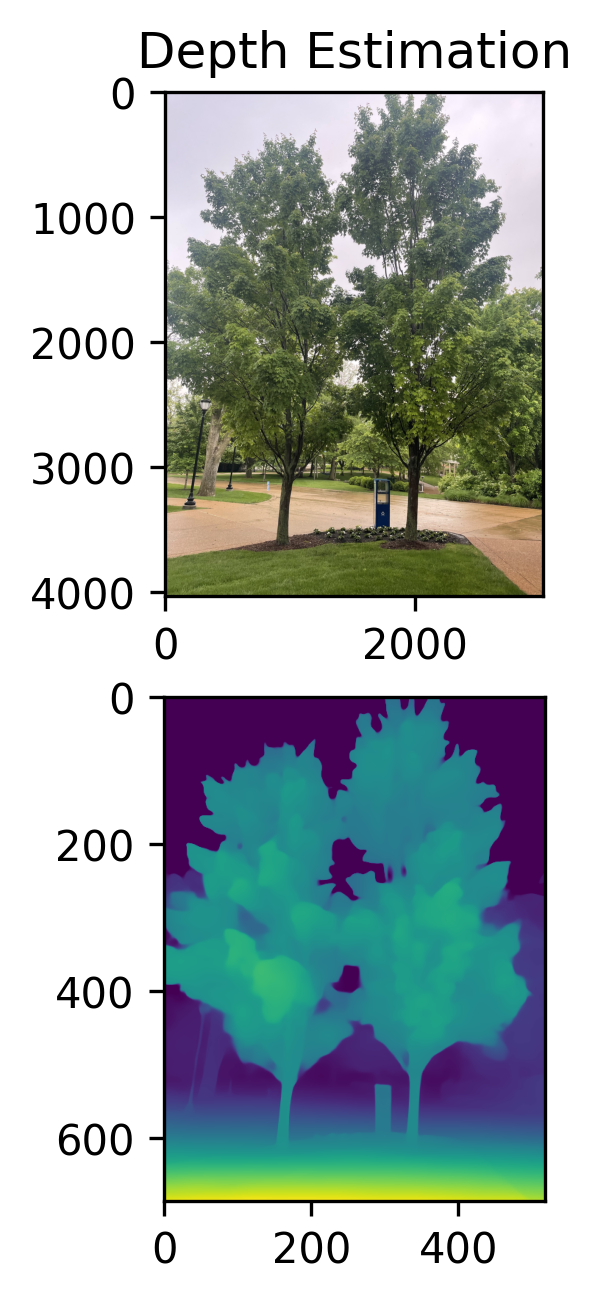

In [12]:
plt.rcParams['figure.dpi'] = 300

for i in range(num_samples):
    fig, axs = plt.subplots(2,1)

    axs[0].imshow(depth_samples[i][0])
    axs[0].set_title("Depth Estimation")
    axs[1].imshow(depth_samples[i][1])

    plt.show()


In [13]:
for i in range(num_samples):
    depth_image = depth_samples[i][1]
    color_image = depth_samples[i][0]
    width, height = depth_image.shape

    depth_image = (depth_image * 255 / np.max(depth_image)).astype(np.uint8)
    color_image = cv2.resize(color_image, (height, width))

    cv2.imwrite('results/'+ str(i)+'.png', cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite('results/' + str(i) + '_depth.png', depth_image)

In [14]:

i = 0  # Assuming you want to visualize the first sample
depth_image = depth_samples[i][1]
color_image = depth_samples[i][0]

width, height = depth_image.shape

depth_image = (depth_image * 255 / np.max(depth_image)).astype(np.uint8)
color_image = cv2.resize(color_image, (height, width))


In [27]:

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(color_image)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
	image_o3d, depth_o3d, convert_rgb_to_intensity=False
)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()

fx = fy = width * 0.8
cx, cy = width / 2, height / 2

camera_intrinsic.set_intrinsics(width, height, fx, fy, cx, cy)

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(
	rgbd_image, camera_intrinsic
)

o3d.visualization.draw_geometries([pcd_raw])

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [29]:
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
pcd = pcd_raw.select_by_index(ind)

# estimate normals

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
o3d.visualization.draw_geometries([pcd])

o3d.io.write_point_cloud("results/point_cloud.ply", pcd)

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True

In [34]:
def depth_to_pointcloud_orthographic(depth_map, image, scale_factor=255):

    height, width = depth_map.shape

    # Create a grid of pixel coordinates
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

    # Scale the depth values
    z = (depth_map / scale_factor) * height/2

    # Create 3D points (x and y are pixel coordinates, z is from the depth map)
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)

    # Filter out points with zero depth
    mask = points[:, 2] != 0
    points = points[mask]

    # Create Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])
    
    # Add colors to the point cloud
    colors = image.reshape(-1, 3)[mask] / 255.0  # Normalize color values to [0, 1]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    _, ind = pcd.remove_statistical_outlier(nb_neighbors=15, std_ratio=1)
    inlier_cloud = pcd.select_by_index(ind)

    return inlier_cloud, z, height, width 

i=0

depth_map = cv2.imread('results/' + str(i) + '_depth.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('results/' + str(i) + '.png')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Convert depth map and image to point cloud
point_cloud, z, height, width  = depth_to_pointcloud_orthographic(depth_map, image)

o3d.visualization.draw_geometries([point_cloud])

o3d.io.write_point_cloud("results/orthographic_point_cloud.ply", point_cloud)

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True

In [35]:
# generating 3D mesh

point_cloud.estimate_normals()
point_cloud.orient_normals_to_align_with_direction()

print('run Poisson surface reconstruction')
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)
o3d.visualization.draw_geometries([mesh])

o3d.io.write_triangle_mesh("results/mesh.ply", mesh, write_vertex_normals=True)

run Poisson surface reconstruction
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] Write Ply clamped color value to valid range


True